In [ ]:
Figure five is a sensitivity analysis across various model parameter variations

# TODO: remove any non-unique parameters, and include the noise parameter (this noise parameter seems to be the issue)

In [1]:
include(joinpath("..","src","setup.jl"))

┌ Info: Loading Cairo backend into Compose.jl
└ @ Compose /Users/davidlittle/.julia/packages/Compose/BYWXX/src/Compose.jl:161
┌ Warning: Package Compose does not have Cairo in its dependencies:
│ - If you have Compose checked out for development and have
│   added Cairo as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Compose
│ Loading Cairo into Compose from project dependency, future warnings for Compose are suppressed.
└ @ nothing nothing:840
┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/davidlittle/.julia/packages/Gadfly/ew1SM/src/mapping.jl:228


RObject{VecSxp}
$rcalljl_options
$rcalljl_options$height
[1] 360

$rcalljl_options$width
[1] 432




In [44]:
datadir = joinpath("..","data","count_lengths","run_2018-12-06")

"../data/count_lengths/run_2018-12-06"

In [45]:
fields = [:f_c_a,:f_c_m,:f_c_σ,:s_c_a,:s_c_m,:s_c_σ,:t_c_a,:t_c_m,:t_c_σ,
          :f_τ_a,:f_τ_m,:s_τ_a,:s_τ_m,:t_τ_a,:t_τ_m];

In [57]:
params = load_params(joinpath(datadir,"params.jld2"))
params[:pindex] = 1:size(params,1)
settings = joinpath("..","src","settings.toml")

results = []
for_results_in(joinpath(datadir,"data")) do entry
  push!(results,DataFrame(length=entry["lengths"],
                          percepts=entry["percepts"].+1, # after +1, indicates the number of streams reported, 1 or 2
                          created=entry["created"],
                          pindex=entry["pindex"])) # the parameter index (pindex = N correspondes to row N of `params`)
end
df = vcat(results...);
head(df)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


,length,percepts,created,pindex
,Float64,Int64,DateTime,Int64
1,0.3,1,2018-12-06T23:52:05.717,1
2,0.9,2,2018-12-06T23:52:05.717,1
3,4.4,1,2018-12-06T23:52:05.717,1
4,0.6,2,2018-12-06T23:52:05.717,1
5,3.0,1,2018-12-06T23:52:05.717,1
6,0.3,2,2018-12-06T23:52:05.717,1


In [58]:
# turns out there are some non-unique parameter values with this; remove those (in the future do it before running the simulation)
uparams = unique!(params,[fields;:Δf])
size(uparams,1)

1575

In [48]:
size(df)

(448632, 4)

In [49]:
dfsel = @where(df,in.(:pindex,Ref(uparams.pindex)));
size(dfsel)

(348782, 4)

In [61]:
uparams[:old_pindex] = uparams.pindex;
dfsel[:old_pindex] = dfsel.pindex;

In [66]:
uparams[:pindex] = 1:size(uparams,1)
for row in 1:size(dfsel,1)
    i = findfirst(isequal(dfsel.old_pindex[row]),uparams.old_pindex)
    if i isa Nothing
        error("Can't find old_pindex $(dfsel.old_pindex[row])")
    end
    dfsel.pindex[row] = uparams.pindex[i]
end
head(dfsel)

,length,percepts,created,pindex,old_pindex
,Float64,Int64,DateTime,Int64,Int64
1,0.3,1,2018-12-06T23:52:05.717,1,1
2,0.9,2,2018-12-06T23:52:05.717,1,1
3,4.4,1,2018-12-06T23:52:05.717,1,1
4,0.6,2,2018-12-06T23:52:05.717,1,1
5,3.0,1,2018-12-06T23:52:05.717,1,1
6,0.3,2,2018-12-06T23:52:05.717,1,1


In [73]:
progress = Progress(nrow(unique(params[fields])))
df_summary = by(uparams,fields) do row
    next!(progress)
    m = model_error(dfsel,params;(k => row[1,k] for k in fields)...)
    DataFrame(stream_error = m.stream,length_error = m.lengths,mean_error = mean((m.stream,m.lengths)),eratio = error_ratio(m))
end
head(df_summary)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


,f_c_a,f_c_m,f_c_σ,s_c_a,s_c_m,s_c_σ,t_c_a,t_c_m,t_c_σ,f_τ_a,f_τ_m,s_τ_a,s_τ_m,t_τ_a,t_τ_m,stream_error,length_error,mean_error,eratio
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Float64,Float64,Float64,Float64
1,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,1.0 s,0.35 s,3.0 s,0.35 s,3.0 s,0.35 s,0.245254,0.0457507,0.145502,1.13455
2,0.0,5.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,1.0 s,0.35 s,3.0 s,0.35 s,3.0 s,0.35 s,0.261338,0.0561534,0.158746,1.24425
3,0.0,63.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,1.0 s,0.35 s,3.0 s,0.35 s,3.0 s,0.35 s,0.271593,0.0453904,0.158492,1.23125
4,0.0,790.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,1.0 s,0.35 s,3.0 s,0.35 s,3.0 s,0.35 s,0.275776,0.0453904,0.160583,1.24688
5,0.0,10000.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,1.0 s,0.35 s,3.0 s,0.35 s,3.0 s,0.35 s,0.275648,0.0453904,0.160519,1.2464
6,5.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,1.0 s,0.35 s,3.0 s,0.35 s,3.0 s,0.35 s,0.255903,0.0388645,0.147384,1.14151


In [75]:
dfplot = @linq df_summary |>
    rename_levels_for([:stream_error,:length_error,:mean_error,:eratio],suffixes=[:c_a,:c_m,:τ_a,:τ_m,:c_σ]) |>
    transform(a = packaxes(:c_a), m = packaxes(:c_m), rand = randn(length(:c_a))) |>
    transform(eratio_str = fmt.("01.2f",:eratio))
              
head(dfplot)

,c_a,c_m,τ_a,τ_m,c_σ,level,stream_error,length_error,mean_error,eratio,a,m,rand,eratio_str
,Float64,Float64,Quantity…,Quantity…,Float64,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,String
1,0.0,0.0,1.0 s,0.35 s,0.2,Peripheral,0.245254,0.0457507,0.145502,1.13455,0.0,0.0,0.474926,1.13
2,0.0,5.0,1.0 s,0.35 s,0.2,Peripheral,0.261338,0.0561534,0.158746,1.24425,0.0,1.5,0.772978,1.24
3,0.0,63.0,1.0 s,0.35 s,0.2,Peripheral,0.271593,0.0453904,0.158492,1.23125,0.0,2.5,0.590054,1.23
4,0.0,790.0,1.0 s,0.35 s,0.2,Peripheral,0.275776,0.0453904,0.160583,1.24688,0.0,3.5,-0.237181,1.25
5,0.0,10000.0,1.0 s,0.35 s,0.2,Peripheral,0.275648,0.0453904,0.160519,1.2464,0.0,5.0,-0.530469,1.25
6,5.0,0.0,1.0 s,0.35 s,0.2,Peripheral,0.255903,0.0388645,0.147384,1.14151,1.5,0.0,-0.127941,1.14


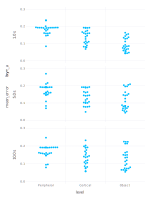

In [79]:
draw(SVG(6inch,8inch),plot(dfplot[dfplot.τ_a .!= 3.0s,:],x=:level,y=:mean_error,ygroup=:τ_a,Geom.subplot_grid(Geom.beeswarm)))

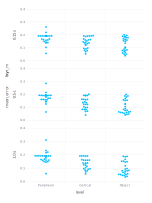

In [80]:
draw(SVG(6inch,8inch),plot(dfplot[dfplot.τ_m .!= 350ms,:],x=:level,y=:mean_error,ygroup=:τ_m,Geom.subplot_grid(Geom.beeswarm)))

In [ ]:
c_σ

In [82]:
draw(SVG(6inch,8inch),plot(dfplot[dfplot.c_σ .!= 0.2,:],x=:level,y=:mean_error,ygroup=:c_σ,Geom.subplot_grid(Geom.beeswarm)))

ArgumentError: ArgumentError: reducing over an empty collection is not allowed